In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

df_train = pd.read_csv("train.csv")

df_train.head()


,CreditScore,Income,LoanAmount,LoanIncomeRatio,NumPayLate,HasCreditCard,Age,SeniorityYears,default
0,698,1902970,233248,0.122571,1,1,59,14,0
1,740,1831064,1251882,0.683691,0,1,49,29,0
2,706,517583,264726,0.511466,2,0,35,26,0
3,715,2761050,1927156,0.697979,0,1,63,27,0
4,652,2535438,1044131,0.411815,1,1,28,16,0


In [51]:
df_train.info()
df_train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      1500 non-null   int64  
 1   Income           1500 non-null   int64  
 2   LoanAmount       1500 non-null   int64  
 3   LoanIncomeRatio  1500 non-null   float64
 4   NumPayLate       1500 non-null   int64  
 5   HasCreditCard    1500 non-null   int64  
 6   Age              1500 non-null   int64  
 7   SeniorityYears   1500 non-null   int64  
 8   default          1500 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 105.6 KB


CreditScore        0
Income             0
LoanAmount         0
LoanIncomeRatio    0
NumPayLate         0
HasCreditCard      0
Age                0
SeniorityYears     0
default            0
dtype: int64

## 1. Data Understanding
- Seleccionar variables numericas relevantes para el clustering (sin la columna default).
- Entender su comportamiento con estadisticas descriptivas.


In [52]:
candidate_cols = [
    "age",
    "income",
    "loan_amount",
    "loan_income_ratio",
    "num_late_payments",
    "debt_to_income",
    "credit_score",
]
available = [c for c in candidate_cols if c in df_train.columns]
other_numeric = [
    c
    for c in df_train.select_dtypes(include="number").columns
    if c not in available and c != "default"
]
num_cols = available if available else other_numeric
if not num_cols:
    raise ValueError("No hay columnas numericas disponibles para clustering.")

X = df_train[num_cols].copy()
print("Columnas usadas para clustering:", num_cols)
X.describe()


Columnas usadas para clustering: ['CreditScore', 'Income', 'LoanAmount', 'LoanIncomeRatio', 'NumPayLate', 'HasCreditCard', 'Age', 'SeniorityYears']


,CreditScore,Income,LoanAmount,LoanIncomeRatio,NumPayLate,HasCreditCard,Age,SeniorityYears
count,1500.000000,1.500000e+03,1.500000e+03,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,653.024000,1.667559e+06,1.067378e+06,0.883388,0.956000,0.702000,45.345333,14.613333
std,70.241398,7.733383e+05,5.539118e+05,0.833721,0.935939,0.457532,14.148623,8.599911
min,415.000000,3.009170e+05,1.002150e+05,0.035970,0.000000,0.000000,21.000000,0.000000
25%,605.000000,9.917760e+05,5.771240e+05,0.360410,0.000000,0.000000,33.000000,7.000000
50%,653.000000,1.714018e+06,1.076043e+06,0.649991,1.000000,1.000000,46.000000,15.000000
75%,701.000000,2.334362e+06,1.547766e+06,1.076670,1.000000,1.000000,57.000000,22.000000
max,850.000000,2.999403e+06,1.995618e+06,6.236456,5.000000,1.000000,69.000000,29.000000


## 2. Data Preparation
- Manejo de nulos solo dentro del set de entrenamiento (imputacion con la media por columna numerica).
- Escalamiento con StandardScaler porque K-Means usa distancia euclidiana sensible a la escala de las variables.


In [53]:
X_prepared = X.copy()
missing = X_prepared.isnull().sum()
if missing.sum() > 0:
    X_prepared = X_prepared.fillna(X_prepared.mean())
    print("Se imputaron nulos con la media en columnas:", missing[missing > 0].index.tolist())
else:
    print("No se encontraron nulos en las columnas seleccionadas.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_prepared)
X_scaled_df = pd.DataFrame(X_scaled, columns=num_cols)
X_scaled_df.head()


No se encontraron nulos en las columnas seleccionadas.


,CreditScore,Income,LoanAmount,LoanIncomeRatio,NumPayLate,HasCreditCard,Age,SeniorityYears
0,0.640520,0.304511,-1.506393,-0.912861,0.047027,0.651538,0.965410,-0.071342
1,1.238657,0.211499,0.333203,-0.239605,-1.021775,0.651538,0.258392,1.673444
2,0.754451,-1.487524,-1.449545,-0.446248,1.115830,-1.534831,-0.731434,1.324486
3,0.882623,1.414460,1.552710,-0.222461,-1.021775,0.651538,1.248217,1.440805
4,-0.014583,1.122625,-0.041983,-0.565813,0.047027,0.651538,-1.226347,0.161296


## 3. Eleccion de numero de clusters (metodo del codo)
- Se prueba K en el rango [2, 8].
- Se grafica la inercia (SSE) para identificar un codo donde la reduccion marginal de error se estabiliza.


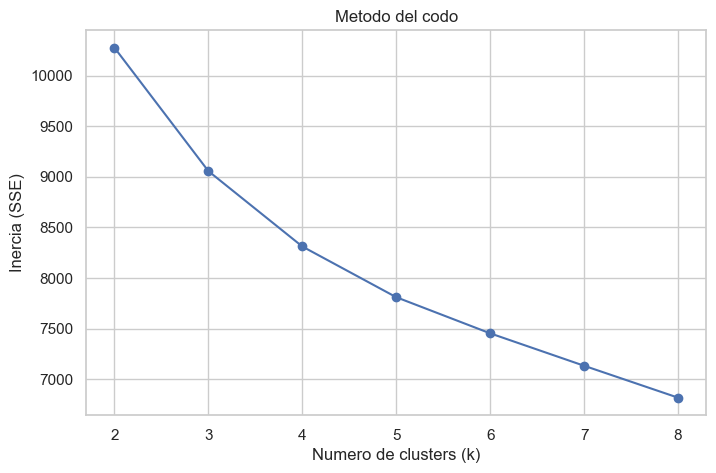

In [54]:
inertia = []
k_range = range(2, 9)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(list(k_range), inertia, marker="o")
plt.title("Metodo del codo")
plt.xlabel("Numero de clusters (k)")
plt.ylabel("Inercia (SSE)")
plt.xticks(list(k_range))
plt.show()


### Interpretacion del codo
Seleccionar un valor de k donde la curva pierde pendiente marcada (ejemplo: 3 o 4). Se fija k_opt manualmente con base en la grafica y conocimiento del negocio.
Se elige K=3 porque en el gráfico del codo hay una fuerte caída de SSE entre K=2 y K=3, la curva se estabiliza después de K=3 y 3 clusters es un número manejable para segmentar riesgo.

## 4. Entrenamiento de K-Means
- Ajuste del modelo con el k_opt elegido.
- Se agrega la etiqueta cluster al DataFrame de entrenamiento. No se utilizan datos de validacion o test.


In [55]:
k_opt = 3
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)

df_train["cluster"] = kmeans.fit_predict(X_scaled)
df_train["cluster"].value_counts().sort_index()


cluster
0    396
1    306
2    798
Name: count, dtype: int64

## 5. Analisis de clusters
- Perfil promedio por cluster en variables numericas.
- Tasa de default por cluster (solo para evaluar, no usada en el entrenamiento no supervisado).


In [56]:
cluster_profile = df_train.groupby("cluster")[num_cols].mean()
cluster_profile


,CreditScore,Income,LoanAmount,LoanIncomeRatio,NumPayLate,HasCreditCard,Age,SeniorityYears
cluster,,,,,,,,
0,649.181818,1.815334e+06,9.562950e+05,0.602523,0.924242,0.000000,46.345960,14.919192
1,659.307190,7.465189e+05,1.432529e+06,2.162540,1.101307,0.833333,44.467320,14.954248
2,652.521303,1.947407e+06,9.824825e+05,0.532262,0.916040,1.000000,45.185464,14.330827


In [57]:
if "default" in df_train.columns:
    cluster_default_rate = df_train.groupby("cluster")["default"].mean()
    print("Tasa de default por cluster:")
    display(cluster_default_rate)
else:
    print("Columna 'default' no encontrada; saltando tasa de default.")


Tasa de default por cluster:


cluster
0    0.267677
1    0.401961
2    0.234336
Name: default, dtype: float64

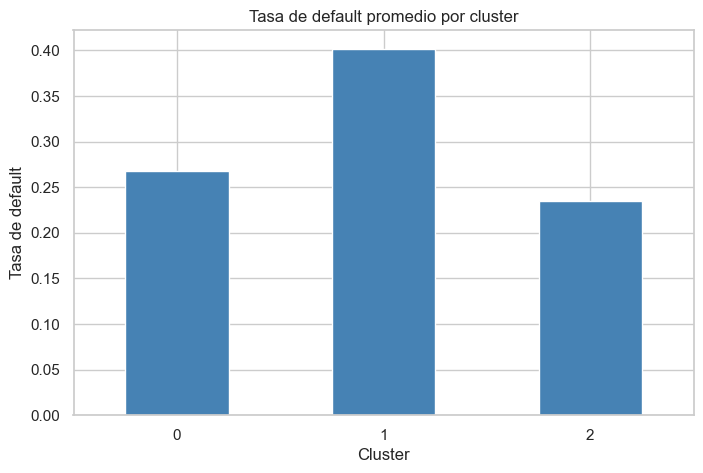

In [58]:
if "default" in df_train.columns:
    ax = df_train.groupby("cluster")["default"].mean().plot(kind="bar", color="steelblue")
    ax.set_ylabel("Tasa de default")
    ax.set_xlabel("Cluster")
    ax.set_title("Tasa de default promedio por cluster")
    plt.xticks(rotation=0)
    plt.show()


## 6. Interpretacion de clusters
Describir los perfiles observados (ejemplo):
- Cluster 0: mayor relacion deuda/ingreso y mas mora -> riesgo mas alto.
- Cluster 1: ingresos medios y morosidad moderada.
- Cluster 2: ingresos altos, pocas moras -> riesgo bajo.

El analisis complementa el modelo supervisado al revelar subsegmentos donde conviene ajustar politicas (precio, campanas, limites de credito) y priorizar monitoreo.


## 7. Conclusiones finales
- K-Means permite segmentar clientes sin usar la etiqueta default, evitando data leakage.
- La etiqueta cluster puede evaluarse como feature adicional en el modelo supervisado (reentrenar y validar antes de usar en produccion).
- Considerar recalibrar periodicamente, inicializaciones distintas y evaluar otras tecnicas (silhouette, DBSCAN, clustering jerarquico) en el futuro.
